In [218]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import IPython.html.widgets as weejet

# get spectral band information for clirad and rrtmg
import rtmtools.clirad.sw.info as cliradswinfo
import rtmtools.clirad.lw.info as cliradlwinfo
import rtmtools.rrtmg.sw.info as rrtmgswinfo
import rtmtools.rrtmg.lw.info as rrtmglwinfo

from IPython.display import HTML

matplotlib.rcParams.update({'xtick.direction': 'out',
                            'xtick.major.size': 7, 'xtick.major.width': 1,
                            'xtick.minor.size': 4, 'xtick.minor.width': 1,
                           'ytick.direction': 'out'})

In [36]:
def get_fpath():
    return '/nuwa_cluster/home/jackyu/climate_models/scam/examples/ARM95/\
cam5_noavg_LW_rrtmgMcICA_rrtmgMcICAaer_SW_rrtmgMcICA_rrtmgMcICAaer/aer_opts.dat'




In [205]:
def get_rrtmg_midband_wavenumbers():
    return [.5 * sum(limits[0]) for iband, limits in rrtmgswinfo.wavenumber_bands().items()]


def preprocess_data():
    df = pd.read_csv(get_fpath(), sep = r'\s+', index_col = [0, 1, 2, 3])
    df.index = df.index.droplevel(1)
    df = df.unstack(1)
    df.index.set_levels(get_rrtmg_midband_wavenumbers(), level=1, inplace = True)
    df.index.rename(['nstep', 'midband wavenubmer'], inplace = True)
    df.columns = df.columns.droplevel(0)
    return df


def quick_plt(df, nstep = 500, layers = None):
    ax = df.loc[(nstep, slice(None))].sort_index().loc[:, layers]\
    .plot(figsize = (10, 11), marker = 'x')
    ax.set_xlabel(r'mid-band wavenumber [$cm^{-1}$]', fontsize = 15.)
    ax.set_ylabel(r'$\tau$', fontsize = 17.)
    ax.set_ylim((0, .02)),
    ax.legend(loc = 'upper left')
    ax.set_xscale('log')
    return




In [159]:
df = preprocess_data()

# Aerosol optical properties

RRTMG-SW 'extinction optical depth' for 31 atmospheric layers at some model timestep.

The wavenumbers are taken to be the in the middle of each spectral band.

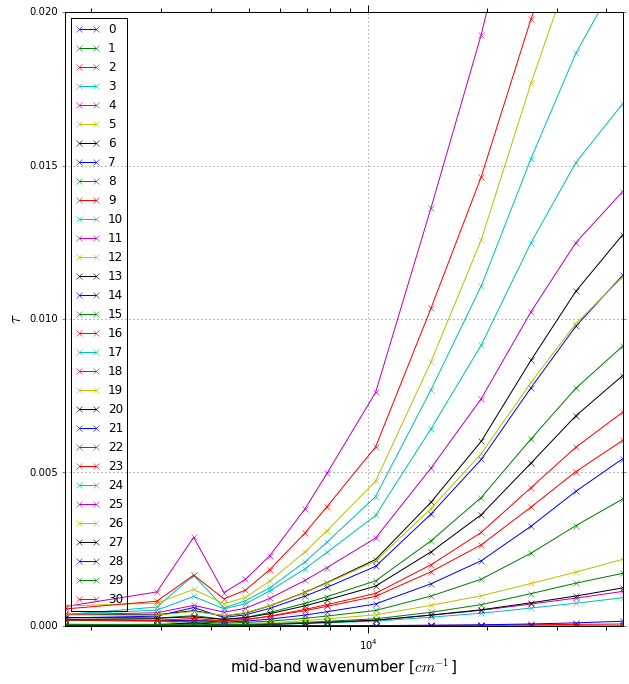

In [221]:
weejet.interact(lambda nstep: \
                quick_plt(df, nstep = nstep, layers = range(30 + 1)),
               nstep = (0, 1225, 1))

In [8]:
HTML('''
<script>
show_code = true;
function code_toggle() {
if (show_code) {$('div.input').hide();} else {$('div.input').show();}
show_code = !show_code
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>
''')